In [1]:
import codecs, json
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import openpyxl
import networkx as nx
from os.path import join

from tqdm import tqdm, tqdm_gui, tqdm_notebook

from multiprocessing.pool import Pool
from functools import partial

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

/home/huze/.conda/envs/torch_geometric/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


In [2]:
scale_list = ['60', '125', '250']
MRS_dir = '/data_59/huze/MRS'
G_path = '/data_59/huze/MRS/G.multi_dim'
tscm_dir = '/data_59/huze/MRS/TSCM'
graph_dir = '/data_59/huze/MRS/G'
atlas_label_sheet = "/data_59/huze/Lausanne/LABELS.xlsx"
subject_dir = '/data_59/huze/Fs.subjects'
subject_list = [line.strip() for line in codecs.open(join(MRS_dir, 'T1/done_subject'), 'r').readlines()]

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.TextIOWrapper name='/data_59/huze/MRS/T1/done_subject' mode='r' encoding='UTF-8'>
  


In [3]:
def read_node_feature(subj_id=str, scale=str, hemi=str):
    """
    read anotomical properties generate by FreeSurfer to a dict,
    only one hemisphere
    """
    stats_dict = dict()
    stats_dict.update({'hemi': hemi})
    
    stats_dict.update({'SubCortical': {'NumVert': 0.0,
                                               'SurfArea': 0.0,
                                               'GrayVol': 0.0,
                                               'ThickAvg': 0.0,
                                               'ThickStd': 0.0,
                                               'MeanCurv': 0.0,
                                               'GausCurv': 0.0,
#                                                'FoldInd': 0.0,
#                                                'CurvInd': 0.0,
                                               'StructName': 'SubCortical'}
                                  })

    stats_file = join(subject_dir, subj_id, 'stats/{0}h.aparc.myatlas_{1}.stats'.format(hemi, scale))
    with open(stats_file, 'r') as infile:
        for line in infile.readlines():
            if not line.startswith('#'):
                StructName = line.split()[0]
                NumVert, SurfArea, GrayVol, ThickAvg, ThickStd, MeanCurv, GausCurv, FoldInd, CurvInd = [float(i) for i in line.split()[1:]]
                stats_dict.update({StructName: {'NumVert': NumVert,
                                               'SurfArea': SurfArea,
                                               'GrayVol': GrayVol,
                                               'ThickAvg': ThickAvg,
                                               'ThickStd': ThickStd,
                                               'MeanCurv': MeanCurv,
                                               'GausCurv': GausCurv,
#                                                'FoldInd': FoldInd,
#                                                'CurvInd': CurvInd,
                                               'StructName': StructName}
                                  })
    return stats_dict

In [4]:
stats_dict = read_node_feature('3064_3', '60', 'r')

In [5]:
stats_dict

{'hemi': 'r',
 'SubCortical': {'NumVert': 0.0,
  'SurfArea': 0.0,
  'GrayVol': 0.0,
  'ThickAvg': 0.0,
  'ThickStd': 0.0,
  'MeanCurv': 0.0,
  'GausCurv': 0.0,
  'StructName': 'SubCortical'},
 'bankssts_1': {'NumVert': 1379.0,
  'SurfArea': 931.0,
  'GrayVol': 3000.0,
  'ThickAvg': 3.04,
  'ThickStd': 0.574,
  'MeanCurv': 0.116,
  'GausCurv': 0.027,
  'StructName': 'bankssts_1'},
 'caudalanteriorcingulate_1': {'NumVert': 1261.0,
  'SurfArea': 893.0,
  'GrayVol': 2378.0,
  'ThickAvg': 2.471,
  'ThickStd': 0.573,
  'MeanCurv': 0.139,
  'GausCurv': 0.03,
  'StructName': 'caudalanteriorcingulate_1'},
 'caudalmiddlefrontal_1': {'NumVert': 2684.0,
  'SurfArea': 1817.0,
  'GrayVol': 5493.0,
  'ThickAvg': 2.67,
  'ThickStd': 0.664,
  'MeanCurv': 0.117,
  'GausCurv': 0.029,
  'StructName': 'caudalmiddlefrontal_1'},
 'cuneus_1': {'NumVert': 2145.0,
  'SurfArea': 1521.0,
  'GrayVol': 3334.0,
  'ThickAvg': 2.038,
  'ThickStd': 0.584,
  'MeanCurv': 0.15,
  'GausCurv': 0.033,
  'StructName': 'cuneus

In [6]:
def map_node_feature_to_node_id(subj_id=str, sheet_file=str, scale=str, hemi=str):
    """
    map anotomical properties to node id in the network,
    only one hemisphere
    """
    feature_map_dict = dict()
    
    stats_dict = read_node_feature(subj_id, scale, hemi)
    
    sheet_name = hemi.upper() + '_' + scale
    wb = openpyxl.load_workbook(sheet_file, read_only=True)
    
    for row in wb[sheet_name]:
        label_id, label_name = row[0].value, row[1].value
        try:
            feature_map_dict.update({label_id: stats_dict[label_name]})
        except KeyError as e:
            feature_map_dict.update({label_id: stats_dict['SubCortical']})
#             feature_map_dict[label_id]['StructName'] = label_name  #TODO: fix buggy {'StructName': 'amygdala'}
            # print(label_id, label_name)
            # print(feature_map_dict[label_id])
                
    return feature_map_dict


In [7]:
feature_map_dict = map_node_feature_to_node_id('3064_3', atlas_label_sheet, '60', 'r')

In [8]:
feature_map_dict

{1: {'NumVert': 1922.0,
  'SurfArea': 1289.0,
  'GrayVol': 3959.0,
  'ThickAvg': 2.673,
  'ThickStd': 0.764,
  'MeanCurv': 0.133,
  'GausCurv': 0.052,
  'StructName': 'lateralorbitofrontal_1'},
 2: {'NumVert': 1575.0,
  'SurfArea': 1109.0,
  'GrayVol': 3207.0,
  'ThickAvg': 2.563,
  'ThickStd': 0.622,
  'MeanCurv': 0.149,
  'GausCurv': 0.044,
  'StructName': 'lateralorbitofrontal_2'},
 3: {'NumVert': 1127.0,
  'SurfArea': 790.0,
  'GrayVol': 2818.0,
  'ThickAvg': 2.704,
  'ThickStd': 0.659,
  'MeanCurv': 0.14,
  'GausCurv': 0.043,
  'StructName': 'parsorbitalis_1'},
 4: {'NumVert': 406.0,
  'SurfArea': 324.0,
  'GrayVol': 1686.0,
  'ThickAvg': 3.058,
  'ThickStd': 1.014,
  'MeanCurv': 0.182,
  'GausCurv': 0.073,
  'StructName': 'frontalpole_1'},
 5: {'NumVert': 1214.0,
  'SurfArea': 866.0,
  'GrayVol': 2779.0,
  'ThickAvg': 2.57,
  'ThickStd': 0.643,
  'MeanCurv': 0.15,
  'GausCurv': 0.044,
  'StructName': 'medialorbitofrontal_1'},
 6: {'NumVert': 1098.0,
  'SurfArea': 772.0,
  'GrayVo

In [9]:
def _create_graph(subj_id=str, connectivity=dict, scale=str):
    """
    create graph for a single subjcet at one scale
    Args:
        connectivity: multi-dimensional connectivity dict
    """
    
    for i, key in enumerate(connectivity.keys()):
        if i == 0:
            G = nx.from_numpy_matrix(connectivity[key])
            # clear edge feature
            for u, v, d in G.edges(data=True):
                d.clear()
        # add multi-dimensional edge features
        for u, v, d in G.edges(data=True):
            d[key] = connectivity[key][u][v]
    
    # map node features
    feature_map_dict = dict()
    feature_map_dict.update(map_node_feature_to_node_id(subj_id, atlas_label_sheet, scale, 'r'))
    feature_map_dict.update(map_node_feature_to_node_id(subj_id, atlas_label_sheet, scale, 'l'))
    
    for node in G.nodes:
        G.nodes[node].update(feature_map_dict[node+1])
    
    return G

In [10]:
correlation_dict = json.load(codecs.open(join(tscm_dir, 'correlation_matrix_sliced_QSDR.scale60.thick.json'),
                                       'r', encoding='utf-8'))

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='/data_59/huze/MRS/TSCM/correlation_matrix_sliced_QSDR.scale60.thick.json'>
  


In [13]:
def _add_time_series(G, timeseries):
    for node in G.nodes:
        G.nodes[node]['TimeSeries'] = timeseries[:, node]
    return G

In [14]:
times_series_dict = json.load(codecs.open(join(tscm_dir, 'time_series_QSDR.scale{0}.thick.json'.format('60')),
                                          'r', encoding='utf-8'))

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='/data_59/huze/MRS/TSCM/time_series_QSDR.scale60.thick.json'>
  


In [24]:
def doubly_stocahstic_normalization(A):
    new_A = np.zeros_like(A)
    tilde_A = A / A.sum(1)
    
    for i in range(0, A.shape[0]):
        for j in range(0, A.shape[1]):
            for k in range(0, A.shape[-1]): # num_nodes
                 new_A[i][j] += tilde_A[i][k] * tilde_A[j][k] / tilde_A[:, k].sum(0)
                
    return new_A

In [25]:
A = np.asarray(correlation_dict['3064_3']['IPBLOCK'])

In [26]:
new_A = doubly_stocahstic_normalization(A)

In [28]:
A.sum(0)[:20]

array([47.45100325, 35.6088118 , 45.73864378, 18.23633745, 31.8110256 ,
       30.5992431 , 42.71090513, 41.27361033, 46.8353855 , 53.31930242,
       50.92805944, 46.11891502, 55.12477668, 54.28688466, 43.88019649,
       39.16749231, 37.62783606, 43.5465113 , 47.4750367 , 42.38171599])

In [29]:
new_A.shape

(129, 129)

In [30]:
new_A.sum(0)[:20]

array([1.18460131, 0.88299449, 1.11903565, 0.31883801, 0.75487964,
       0.67042075, 1.07209634, 1.13664821, 1.31594771, 1.35655717,
       1.30132439, 1.16850608, 1.3840326 , 1.34355166, 1.23308664,
       1.18505384, 1.15293243, 0.99082972, 1.05523803, 1.02010087])

In [46]:
G.degree[0]

130

In [47]:
def _add_node_degree(G):
    pass
    # NOTE: the graph is fully connected with multi dimentional edge attributes

In [32]:
def create_graph_for_one_subject(scale, corr_dict, times_series_dict, subject):
    time_series = times_series_dict[subject]
    connectivity = corr_dict[subject]
    assert len(connectivity.keys()) == 3 # three dimension

    for slice_name in connectivity.keys():
        correlation = np.asarray(connectivity[slice_name])
        # transform correlation to distance by $d = \sqrt{(1 + c) / 2}$
        distance = np.sqrt((correlation + 1) / 2)
        distance[distance == 0] = 1e-3
#         # doubly stocahstic normalization of E
#         E = doubly_stocahstic_normalization(distance)
        E = distance
        # make the graph fully connected for multi-dimensional edge feature / spectral convolution
        assert np.count_nonzero(E) == E.shape[0] * E.shape[1]
        connectivity[slice_name] = E

    G = _create_graph(subject, connectivity, scale)
#     G = _add_time_series(G, np.asarray(time_series))

    # write to file
    subject_G_path = join(G_path, 'subj{0}.scale{1}.json'.format(subject, scale))
    json_graph = nx.node_link_data(G)
    json.dump(json_graph, codecs.open(subject_G_path, 'w', encoding='utf-8'), separators=(',', ':'),
             indent=4, cls=NumpyEncoder)

In [33]:
def create_graphs(subject_list, scale_list):
    """
    create graphs at different scale on all subjects
    """
    
    for scale in tqdm_notebook(scale_list):
        corr_dict = json.load(codecs.open(join(tscm_dir, 'correlation_matrix_sliced_QSDR.scale{0}.thick.json'.format(scale)),
                                          'r', encoding='utf-8'))
        times_series_dict = json.load(codecs.open(join(tscm_dir, 'time_series_QSDR.scale{0}.thick.json'.format(scale)),
                                          'r', encoding='utf-8'))
        # multiprocessing
        pool = Pool(56)
        func = partial(create_graph_for_one_subject, scale, corr_dict, times_series_dict)
        pool.map(func, subject_list)
        pool.close()
        pool.join()

In [34]:
# if i == 0:
# print('Working on {} dimensional edge features: '.format(len(connectivity.keys())), list(connectivity.keys()))
# # check if node is missing
# if i == 0:
#     sample_G = G
# if G.number_of_nodes() != sample_G.number_of_nodes():
#     print('Missing node in subject {}'.format(subject))
# G.number_of_nodes() == sample_G.number_of_nodes()
# # check if fully connected
# for node in G.nodes:
#     assert len(G[node]) == G.number_of_nodes()

In [35]:
create_graphs(['3044_1', '3064_3'], ['60'])

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='/data_59/huze/MRS/TSCM/correlation_matrix_sliced_QSDR.scale60.thick.json'>
  
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:10: ResourceWarning: unclosed file <_io.BufferedReader name='/data_59/huze/MRS/TSCM/time_series_QSDR.scale60.thick.json'>
  # Remove the CWD from sys.path while we load stuff.
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3044_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3064_3.scale60.json'>


In [36]:
G = nx.node_link_graph(json.load(codecs.open(join(G_path, 'subj3044_1.scale60.json'),
                                          'r', encoding='utf-8')))

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='/data_59/huze/MRS/G.multi_dim/subj3044_1.scale60.json'>
  


In [37]:
G.number_of_edges()

8385

In [38]:
G[0][1]

{'IPBLOCK': 0.8886338781261297,
 'RESTBLOCK': 0.8721361808207777,
 'WHOLE': 0.9336350882727398}

In [39]:
len(G.nodes[0]['TimeSeries'])

KeyError: 'TimeSeries'

In [40]:
cm = nx.adj_matrix(G).toarray()

In [41]:
cm

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

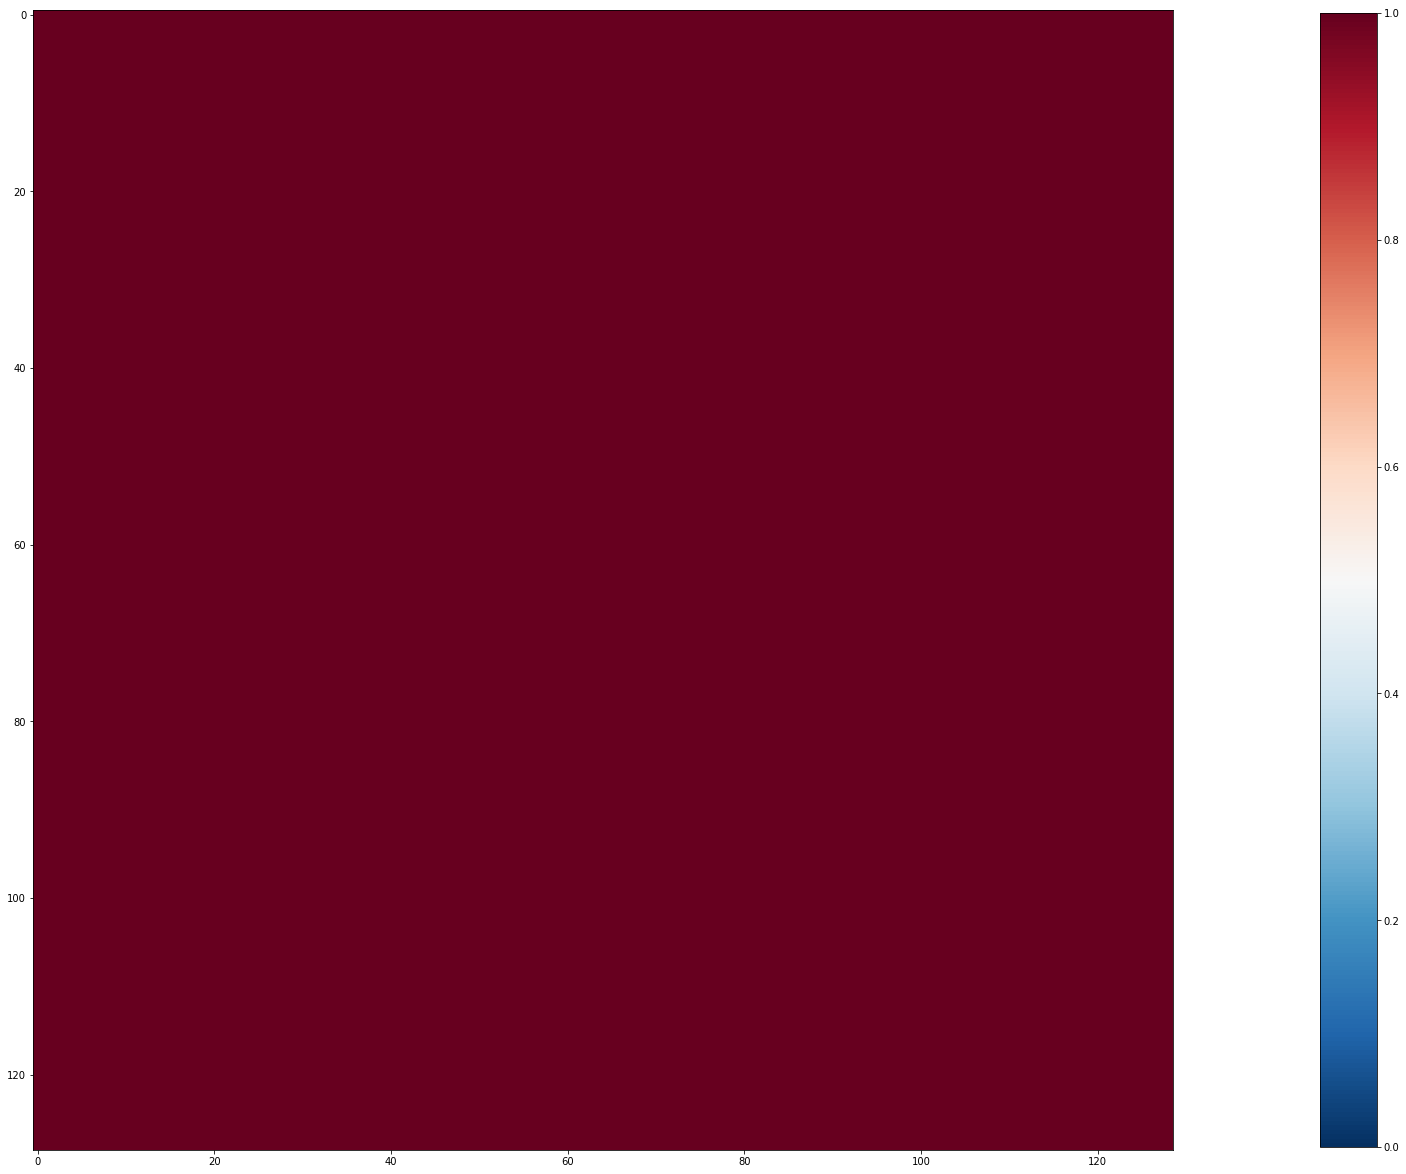

In [25]:
from nilearn import plotting
plotting.plot_matrix(cm, colorbar=True, vmax=1, vmin=0, figure=(20, 20))

In [42]:
scale_list = ['60']

In [43]:
create_graphs(subject_list, scale_list)

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='/data_59/huze/MRS/TSCM/correlation_matrix_sliced_QSDR.scale60.thick.json'>
  
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:10: ResourceWarning: unclosed file <_io.BufferedReader name='/data_59/huze/MRS/TSCM/time_series_QSDR.scale60.thick.json'>
  # Remove the CWD from sys.path while we load stuff.
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3059_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3027_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: Res

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2008_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3025_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2058_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2029_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3052_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3013_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3017_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2077_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3016_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3022_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2090_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3010_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2103_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2032_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3012_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2092_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3025_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2050_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj3057_3.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2090_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_

/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2032_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2005_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2064_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_dim/subj2024_1.scale60.json'>
/home/huze/.conda/envs/torch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:25: ResourceWarning: unclosed file <_io.BufferedWriter name='/data_59/huze/MRS/G.multi_